In [18]:
#required imports
import sys 
print (sys.version) #print python version
%pylab inline
from scipy import special as sp
from scipy import interpolate
from numpy import linalg as la
import cmath
#from joblib import Parallel, delayed
#from numba import autojit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

3.5.2+ (default, Sep 22 2016, 12:18:14) 
[GCC 6.2.0 20160927]
Populating the interactive namespace from numpy and matplotlib


/home/nicolas/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['source', 'gradient']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
#spherical harmonics redefinition - workaround for https://github.com/ContinuumIO/anaconda-issues/issues/479 - Probably no longer needed

def _sph_harm_norm(order, degree):
    """Normalization factor for spherical harmonics"""
    # we could use scipy.special.poch(degree + order + 1, -2 * order)
    # here, but it's slower for our fairly small degree
    norm = np.sqrt((2 * degree + 1.) / (4 * np.pi))
    if order != 0:
        norm *= np.sqrt(sp.factorial(degree - order) /
                        float(sp.factorial(degree + order)))
    return norm


def _sph_harm(order, degree, az, pol, norm=True):
    """Evaluate point in specified multipolar moment. [1]_ Equation 4.
    When using, pay close attention to inputs. Spherical harmonic notation for
    order/degree, and theta/phi are both reversed in original SSS work compared
    to many other sources. See mathworld.wolfram.com/SphericalHarmonic.html for
    more discussion.
    Note that scipy has ``scipy.special.sph_harm``, but that function is
    too slow on old versions (< 0.15) for heavy use.
    Parameters
    ----------
    order : int
        Order of spherical harmonic. (Usually) corresponds to 'm'.
    degree : int
        Degree of spherical harmonic. (Usually) corresponds to 'l'.
    az : float
        Azimuthal (longitudinal) spherical coordinate [0, 2*pi]. 0 is aligned
        with x-axis.
    pol : float
        Polar (or colatitudinal) spherical coordinate [0, pi]. 0 is aligned
        with z-axis.
    norm : bool
        If True, include normalization factor.
    Returns
    -------
    base : complex float
        The spherical harmonic value.
    """
    from scipy.special import lpmv

    # Error checks
    if np.abs(order) > degree:
        raise ValueError('Absolute value of order must be <= degree')
    # Ensure that polar and azimuth angles are arrays
    az = np.asarray(az)
    pol = np.asarray(pol)
    if (np.abs(az) > 2 * np.pi).any():
        raise ValueError('Azimuth coords must lie in [-2*pi, 2*pi]')
    if(pol < 0).any() or (pol > np.pi).any():
        raise ValueError('Polar coords must lie in [0, pi]')
    # This is the "seismology" convention on Wikipedia, w/o Condon-Shortley
    if norm:
        norm = _sph_harm_norm(order, degree)
    else:
        norm = 1.
    return norm * lpmv(order, degree, np.cos(pol)) * np.exp(1j * order * az)

In [20]:
# Class containing the optical properties of the tissue and/or inclusion
class PO:
    def __init__(self, mua, mups, muaf, mupsf, sigma, concentration, tau):
        self.mua = mua
        self.mups = mups
        self.muaf = muaf
        self.mupsf = mupsf
        self.D = v/(3.*mups)
        self.Df = v/(3.*mupsf)
        self.sigma = sigma
        self.N = concentration
        self.t = tau

In [21]:
def AAprox (n):
    if n > 1:
        A = 504.332889 - 2641.00214 * n + 5923.699064 * n**2 - 7376.355814 * n**3 + \
        5507.53041 * n**4 - 2463.357945 * n**5 + \
        610.956547 * n**6 - 64.8047 * n**7
    if n <= 1:
        A = 3.084635 - 6.531194 * n + 8.357854 * \
        n**2 - 5.082751 * n**3 + 1.171382 * n**4
    
    return A

In [22]:
#@autojit
def Phi (det, source, tissue, inclusion, alpha):
    """
    Infinite heterogeneous DPDW 
    
    det: detector position (x,y,z) [floats]
    source: source position (x,y,z) [floats]
    tissue: tissue information (mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau), [PO][floats]
    inclusion: inclusion information (mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau), [PO][floats]
    alpha: inclusion radius [float]
    """
    
    A = AAprox(n)
        
    D1 = tissue.D
    D1f = tissue.Df
    D2 = inclusion.D
    D2f = inclusion.Df
    k1 = cmath.sqrt(-v*tissue.mua/D1)
    k1f = cmath.sqrt(-v*tissue.muaf/D1f)
    k2 = cmath.sqrt(-v*inclusion.mua/D2)
    k2f = cmath.sqrt(-v*inclusion.muaf/D2f) 
    N1 = tissue.N
    N2 = inclusion.N
    sigma = tissue.sigma
    t1 = tissue.t
    t2 = inclusion.t
    
    sum_inside = 0
    sum_outside = 0
    
    r = la.norm(np.asarray(det))
    s = la.norm(np.asarray(source))
    
    sep = la.norm(np.asarray(det)-np.asarray(source))
    theta_det = np.arccos(det[2]/r)# + math.pi #elevation r in spherical coordinates
    phi_det = np.arctan2(det[1],det[0]) #+ math.pi ##azimuth r in spherical coordinates
    theta_source = np.arccos(source[2]/s)# + math.pi #elevation s in spherical coordinates
    phi_source = np.arctan2(source[1],source[0]) #+ math.pi  #azimuth r in spherical coordinates


    if alpha > 0:
    #inhomogeneous case (eq 25, p3751, Fluorescent diffusie photon density waves in homogeneous and heteregeneous turbid media..., Li et. al.)
        
        #spherical bessel and hankel functions
        #see: http://docs.scipy.org/doc/scipy-0.16.1/reference/special.html and http://www.johndcook.com/blog/bessel_functions/
        sphbessel1 = sp.sph_jn(L,k1*alpha)
        sphbessel1f = sp.sph_jn(L,k1f*alpha)
        sphbessel2 = sp.sph_jn(L,k2*alpha)
        sphbessel2f = sp.sph_jn(L,k2f*alpha)
        sphhankel1 = sp.sph_jn(L,k1*alpha)[0] + 1j * sp.sph_yn(L,k1*alpha)[0]
        sphhankel1v = sp.sph_jn(L,k1*alpha)[1] + 1j * sp.sph_yn(L,k1*alpha)[1]
        sphhankel1f = sp.sph_jn(L,k1f*alpha)[0] + 1j * sp.sph_yn(L,k1f*alpha)[0]
        sphhankel1vf = sp.sph_jn(L,k1f*alpha)[1] + 1j * sp.sph_yn(L,k1f*alpha)[1]
        sphhankel2 = sp.sph_jn(L,k2*alpha)[0] + 1j * sp.sph_yn(L,k2*alpha)[0]
        sphhankel2v = sp.sph_jn(L,k2*alpha)[1] + 1j * sp.sph_yn(L,k2*alpha)[1]
        sphhankel1r = sp.sph_jn(L,k1*r)[0] + 1j * sp.sph_yn(L,k1*r)[0]
        sphhankel1s = sp.sph_jn(L,k1*s)[0] + 1j * sp.sph_yn(L,k1*s)[0]
        sphhankel1rf = sp.sph_jn(L,k1f*r)[0] + 1j * sp.sph_yn(L,k1f*r)[0]
        sphhankel1sf = sp.sph_jn(L,k1f*s)[0] + 1j * sp.sph_yn(L,k1f*s)[0]

        for l in range (0,L):
            #list_out = Parallel(n_jobs=2)(delayed(term_outside)(l, m, det, source, tissue, inclusion, alpha, sum_inside, sum_outside) for m in range(-l,l))
            #list_in = Parallel(n_jobs=2)(delayed(term_outside)(l, m, det, source, tissue, inclusion, alpha, sum_inside, sum_outside) for m in range(-l,l))

            for m in range (-l+1,l):

                #Constants for analytic solutions (p3756, Fluorescent diffusie photon density waves in homogeneous and heteregeneous turbid media..., Li et. al.)
                Ql = (D2 * k2 * sphbessel1[0][l] * sphbessel2[1][l] - D1 * k1 * sphbessel1[1][l] * sphbessel2[0][l])/ \
                     (D2 * k2 * sphhankel1[l] * sphbessel2[1][l] - D1 * k1 * sphhankel1v[l] * sphbessel2[0][l])

                Qlf = (D2f * k2f * sphbessel1f[0][l] * sphbessel2f[1][l] - D1f * k1f * sphbessel1f[1][l] * sphbessel2f[0][l])/ \
                      (D2f * k2f * sphhankel1f[l] * sphbessel2f[1][l] - D1f * k1f * sphhankel1vf[l] * sphbessel2f[0][l])

                Rl = 1. / (alpha**2 * (D2 * k2 * sphhankel1[l] * sphbessel2[1][l] - D1 * k1 * sphhankel1v[l] * sphbessel2[0][l]))

                Rlf = 1. / (alpha**2 * (D2f * k2f * sphhankel1f[l] * sphbessel2f[1][l] - D1f * k1f * sphhankel1vf[l] * \
                      sphbessel2f[0][l]))

                Sl = (D2 * k2 * sphhankel1[l] * sphhankel2v[l] - D1 * k1 * sphhankel1v[l] * sphhankel2[l])/ \
                     (D2 * k2 * sphhankel1[l] * sphbessel2[1][l] - D1 * k1 * sphhankel1v[l] * sphbessel2[0][l])

                El = (D2f * k2f * sphhankel1[l] * sphbessel2f[1][l] - D1f * k1 * sphhankel1v[l] * sphbessel2f[0][l])/ \
                     (D2f * k2f * sphhankel1f[l] * sphbessel2f[1][l] - D1f * k1f * sphhankel1vf[l] * sphbessel2f[0][l])

                Fl = (D2f * k2f * sphbessel1[0][l] * sphbessel2f[1][l] - D1f * k1 * sphbessel1[1][l] * sphbessel2f[0][l])/ \
                     (D2f * k2f * sphhankel1f[l] * sphbessel2f[1][l] - D1f * k1f * sphhankel1vf[l] * sphbessel2f[0][l])

                #(p3750, eq 20, Fluorescent diffusie photon density waves in homogeneous and heteregeneous turbid media..., Li et. al.)
                sum_inside += ((k2f * sphbessel2[0][l] *sphbessel2f[1][l] - \
                                k2 * sphbessel2[1][l] * sphbessel2f[0][l]) * Rl * Rlf * \
                                sphhankel1rf[l] * sphhankel1s[l] * \
                                (sp.sph_harm(m,l,phi_det,theta_det) *  np.conjugate(sp.sph_harm(m,l,phi_source,theta_source))))
                #(p3751, eq 24, Fluorescent diffusie photon density waves in homogeneous and heteregeneous turbid media..., Li et. al.)
                sum_outside += (1j * k1f * Qlf * sphhankel1rf[l] * sphhankel1sf[l] + \
                           (-1j) * k1 * Ql * sphhankel1r[l] * sphhankel1s[l] + \
                           1j * k1 * Ql * El * sphhankel1rf[l] * sphhankel1s[l] + \
                           (-1j) * k1 * Fl * sphhankel1rf[l] * sphhankel1s[l]) * \
                           (np.conjugate(sp.sph_harm(m,l,phi_source,theta_source)*sp.sph_harm(m,l,phi_det,theta_det)))


        exp_outside = cmath.exp(1j*k1*sep)/(4*math.pi*sep) - cmath.exp(1j*k1f*sep)/(4*math.pi*sep)
        phi_inside = M0*v**2. * ((sigma*N2)/(1. - 1j*w*t2)) * (alpha**2./(k2**2 - k2f**2)) * sum_inside
        phi_outside = M0*v**2./(D1*D1f) * sigma*N1/(1. - 1j*w*t1) * 1/(k1**2-k1f**2) * (exp_outside + sum_outside)
        phi = phi_inside + phi_outside 
    
    else:
    #Infinite homogeneous DPDW (eq 6, p3748, Fluorescent diffusie photon density waves in homogeneous and heteregeneous turbid media..., Li et. al.)
        
        D1 = tissue.D
        D1f = tissue.Df
        k1 = cmath.sqrt(-v*tissue.mua/D1)
        k1f = cmath.sqrt(-v*tissue.muaf/D1f)
        N1 = tissue.N
        sigma = tissue.sigma
        t1 = tissue.t
        sep = la.norm(np.asarray(det)-np.asarray(source))

        exp_homo = cmath.exp(1j*k1*sep)/(4*math.pi*sep) - cmath.exp(1j*k1f*sep)/(4*math.pi*sep)
        phi = M0*v**2./(D1*D1f) * sigma*N1/(1. - 1j*w*t1) * 1/(k1**2-k1f**2) * exp_homo

    return phi

In [23]:
def PhiHomo (det, source, tissue): #another special case for no inclusion - probably working better
    
    """
    Infinite heterogeneous DPDW (eq 25, p3751, Fluorescent diffusie photon density waves in homogeneous and heteregeneous turbid media..., Li et. al.)
    Special case for no inclusion - probably working better
    
    det: detector position (x,y,z) [floats]
    source: source position (x,y,z) [floats]
    tissue: tissue information (mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau), [floats]
    """
       
    D1 = tissue.D
    D1f = tissue.Df
    k1 = cmath.sqrt(-v*tissue.mua/D1)
    k1f = cmath.sqrt(-v*tissue.muaf/D1f)
    N1 = tissue.N
    sigma = tissue.sigma
    t1 = tissue.t
    sep = la.norm(np.asarray(det)-np.asarray(source))
    
    exp_homo = cmath.exp(1j*k1*sep)/(4*math.pi*sep) - cmath.exp(1j*k1f*sep)/(4*math.pi*sep)
    phi_homo = M0*v**2./(D1*D1f) * sigma*N1/(1. - 1j*w*t1) * 1/(k1**2-k1f**2) * exp_homo
    
    return phi_homo

In [24]:
def Phi_OffCenter (det, source, tissue, inclusion, inclusion_geo, alpha): 
    """
    Phi function redefined for an offcenter inclusion
    
    det: detector position (x,y,z) [floats]
    source: source position (x,y,z) [floats]
    tissue: tissue information (mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau), [floats]
    inclusion: inclusion information (mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau), [PO][floats]    
    inclusion_geo: inclusion position (x,y,z) [floats]
    alpha: inclusion radius [float]    
    """
    det_offcenter = [det[0] + inclusion_geo[0], det[1] + inclusion_geo[1], det[2] + inclusion_geo[2]]
    source_offcenter = [source[0] + inclusion_geo[0], source[1] + inclusion_geo[1], source[2] + inclusion_geo[2]]
    return Phi(det_offcenter, source_offcenter, tissue, inclusion, alpha)

In [25]:
def PhiHomo_OffCenter (det, source, tissue, inclusion_geo): 
    """
    PhiHomo function redefined for an offcenter inclusion
    
    det: detector position (x,y,z) [floats]
    source: source position (x,y,z) [floats]
    tissue: tissue information (mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau), [floats]
    inclusion_geo: inclusion position (x,y,z) [floats]
    alpha: inclusion radius [float]    
    """
    det_offcenter = [det[0] + inclusion_geo[0], det[1] + inclusion_geo[1], det[2] + inclusion_geo[2]]
    source_offcenter = [source[0] + inclusion_geo[0], source[1] + inclusion_geo[1], source[2] + inclusion_geo[2]]
    return PhiHomo(det_offcenter, source_offcenter, tissue)

In [26]:
#Phi for slab geometry
#Assuming detectors located at surface. Extrapolated boundary condition 
#Fluorescent heterogeneities in turbid media..., X. Li et al, 1998, p6836, fig 2
#Virtual sources as defined  in "Light propagation through biological tissue", Martelli et al, p64

def virtual_sources (D, zs, mups, m, iss):
    A = AAprox(n)
    ze = 2*A*D/v
    if iss:
        zs = zs - 1/mups
    #print ze
    plus_source = 2*m*(d + 2*ze) + zs
    minus_source = 2*m*(d + 2*ze) - 2*ze - zs
    #print (plus_source, minus_source)
    return plus_source, minus_source
    
def Phi_Slab (det, source, tissue, inclusion, inclusion_geo, alpha):
    sum_plus = np.float64(0.0)
    sum_minus = np.float64(0.0)
    list_sources = []
    list_inclusions = []
    for m in range (-M+1,M):
        virtual_source_plus = [source[0], source[1], virtual_sources(tissue.D, source[2], tissue.mups, m, True)[0]]
        virtual_inclusion_plus = [inclusion_geo[0], inclusion_geo[1], virtual_sources(tissue.D, inclusion_geo[2], tissue.mups, m, False)[0]]
        sum_plus +=  Phi_OffCenter(det, virtual_source_plus, tissue, inclusion, virtual_inclusion_plus, alpha)
        list_sources.append(["+",virtual_source_plus])
        list_inclusions.append(["+",virtual_inclusion_plus])
        virtual_source_minus = [source[0], source[1], virtual_sources(tissue.D, source[2], tissue.mups, m, True)[1]]
        virtual_inclusion_minus = [inclusion_geo[0], inclusion_geo[1], virtual_sources(tissue.D, inclusion_geo[2], tissue.mups, m, False)[1]]
        sum_minus +=  Phi_OffCenter(det, virtual_source_minus, tissue, inclusion, virtual_inclusion_minus, alpha)
        list_sources.append(["-",virtual_source_minus])
        list_inclusions.append(["-",virtual_inclusion_minus])
    #print ("Sources:")
    #print (list_sources)
    #print ("Inclusions:")
    #print (list_inclusions)
    return sum_plus-sum_minus #, list_sources, list_inclusions

M = 2 #Number of virtual sources and inclusions for Slab geometry 

def Phi_Slab2 (det, source, tissue, inclusion, inclusion_geo, alpha): #manual calculation of virtual sources
    A = AAprox(n)
    p1 = 2*A*tissue.D/v
    #p1 = 2*0.7/tissue.mups #Extrapolated boundary condition - virtual plane 1
    #p2 = -(d + 2*0.7/tissue.mups) #Extrapolated boundary condition - virtual plane 2
    p2 = -(d + 2*A*tissue.D/v)
    extrapolated_source = [source[0], source[1], source[2]]
    extrapolated_inclusion = [inclusion_geo[0], inclusion_geo[1], inclusion_geo[2]]
    #print (p1)
    virtual_source1 = [source[0], source[1], source[2] + 2*p1]
    virtual_inclusion1 = [inclusion_geo[0], inclusion_geo[1], inclusion_geo[2] + 2*p1]
    virtual_source2 = [source[0], source[1], source[2] - 2*p2]
    virtual_inclusion2 = [inclusion_geo[0], inclusion_geo[1], inclusion_geo[2] - 2*p2]
    virtual_source3 = [source[0], source[1], source[2] + 2*p2 + p1]
    virtual_inclusion3 = [inclusion_geo[0], inclusion_geo[1], -inclusion_geo[2] + 2*p2 + p1]
    virtual_source4 = [source[0], source[1], source[2] - 2*p2 - 2*p1]
    virtual_inclusion4 = [inclusion_geo[0], inclusion_geo[1], -inclusion_geo[2] - 2*p2 - 2*p1]
    virtual_source5 = [source[0], source[1], source[2] + 2*p2 + 3*p1 ]
    virtual_inclusion5 = [inclusion_geo[0], inclusion_geo[1], +inclusion_geo[2] + 2*p2 + 3*p1]
    virtual_source6 = [source[0], source[1], source[2] - 3*p2 - 2*p1 ]
    virtual_inclusion6 = [inclusion_geo[0], inclusion_geo[1], -inclusion_geo[2] - 3*p2 - 2*p1]
    
    return Phi_OffCenter(det, extrapolated_source, tissue, inclusion, extrapolated_inclusion, alpha)\
           - Phi_OffCenter(det, virtual_source1, tissue, inclusion, virtual_inclusion1, alpha)\
           - Phi_OffCenter(det, virtual_source2, tissue, inclusion, virtual_inclusion2, alpha)\
           + Phi_OffCenter(det, virtual_source3, tissue, inclusion, virtual_inclusion3, alpha)\
           + Phi_OffCenter(det, virtual_source4, tissue, inclusion, virtual_inclusion4, alpha)\
           - Phi_OffCenter(det, virtual_source5, tissue, inclusion, virtual_inclusion5, alpha)\
           - Phi_OffCenter(det, virtual_source6, tissue, inclusion, virtual_inclusion6, alpha)
    

In [10]:
# Parameters initialization
L = 10 #Number of bessel functions
n = 1.33
v = 29979245800/n 
M0 = 1.
w = 0.

In [11]:
# Variable parameters
n = 1.33
d = 5. #Slab width
N_tissue = 10
N_inclusion = 60
mua_ex_medium = 0.04+N_tissue*1e-9*339625
mua_ex_inc = 0.08+N_inclusion*1e-9*339625
mua_fl_medium = 0.04+N_tissue*1e-9*219500
mua_fl_inc = 0.08+N_inclusion*1e-9*219500
print (mua_ex_medium, mua_fl_medium, mua_ex_inc, mua_fl_inc)
tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) #mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau
inclusion = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9) #mua (muadye_ex), mups, muaf (muadye_fl), mupsf, sigma, concentration, tau
inclusion_geo = [-2.1,0,1.35] #object containing the inclusion position [x,y,z]- maybe it should contain size also
inclusion_radius = 0.595
source = [0.,0.,0.]

0.04339625 0.042195 0.10037750000000001 0.09317


In [12]:
# Variable parameters (transmitance)
n = 1.33
d = 4. #Slab width
N_tissue = 10
N_inclusion = 35
mua_ex_medium = 0.045+N_tissue*1e-9*339625
mua_ex_inc = 0.085+N_inclusion*1e-9*339625
mua_fl_medium = 0.045+N_tissue*1e-9*219500
mua_fl_inc = 0.085+N_inclusion*1e-9*219500
tissue = PO(mua_ex_medium, 7.74, mua_fl_medium, 7.74, 6e4, N_tissue*1e-9, 0.58e-9) #mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau
inclusion = PO(mua_ex_inc, 7.74, mua_fl_inc, 7.74, 6e4, N_inclusion*1e-9, 0.58e-9) #mua (muadye_ex), mups, muaf (muadye_fl), mupsf, sigma, concentration, tau
inclusion_geo = [0.,0,3.] #object containing the inclusion position [x,y,z]- maybe it should contain size also
inclusion_radius = 0.57
source = [0.,0.,0.]
print (mua_ex_medium, mua_fl_medium, mua_ex_inc, mua_fl_inc)

0.04839625 0.047195 0.09688687500000001 0.0926825


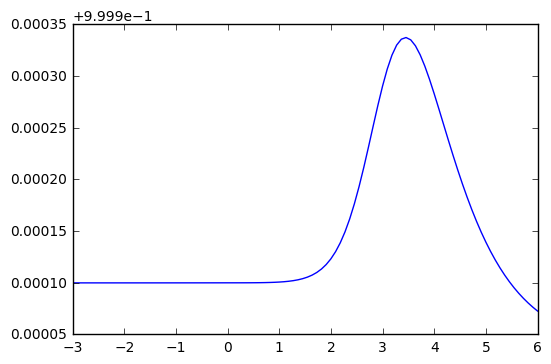

In [13]:
#y coordinate index for calculations and plots
Npoints= 100
index = np.linspace(-3, 6, Npoints)

#Computation of division of case with inclusion and withouth inclusion - infinite reflectance case
fluence_2d_inf = []
fluence_2d_inc_inf = []
fluence_2d_back_inf = []
foreground_inf = []
background_inf = []

for i in index:
    foreground_inf = Phi_OffCenter ([i,0,0.000001], [0,0,0], tissue, inclusion, [-3.1,0,1.35], inclusion_radius)
    background_inf = Phi_OffCenter ([i,0,0.000001], [0,0,0], tissue, inclusion, [-3.1,0,1.35], 0)      
    fluence_2d_inf.append(foreground_inf/background_inf)
    fluence_2d_back_inf.append(background_inf)
    fluence_2d_inc_inf.append(foreground_inf)

plot(index, np.real(fluence_2d_inf))

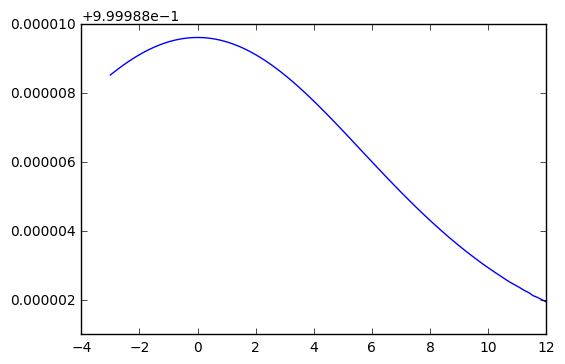

In [14]:
#y coordinate index for calculations and plots
Npoints= 100
index = np.linspace(-3, 12, Npoints)

#Computation of division of case with inclusion and withouth inclusion - infinite transmitance case
fluence_2d_inf = []
fluence_2d_inc_inf = []
fluence_2d_back_inf = []
foreground_inf = []
background_inf = []

for i in index:
    foreground_inf = Phi_OffCenter ([i,0,4.], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)
    background_inf = Phi_OffCenter ([i,0,4.], [0,0,0], tissue, inclusion, inclusion_geo, 0)      
    fluence_2d_inf.append(foreground_inf/background_inf)
    fluence_2d_back_inf.append(background_inf)
    fluence_2d_inc_inf.append(foreground_inf)

plot(index, np.real(fluence_2d_inf))

In [15]:
#y coordinate index for calculations and plots
Npoints= 100
index = np.linspace(-3, 10, Npoints)

#Computation of division of case with inclusion and withouth inclusion - slab reflectance case
fluence_2d_slab2 = []
fluence_2d_inc_slab2 = []
fluence_2d_back_slab2 = []
foreground_slab2 = []
background_slab2 = []
M=2
for i in index:
    foreground_slab2 = Phi_Slab2 ([i,0,0.000001], [0,0,0], tissue, inclusion, [-3.1,0,1.35], inclusion_radius)
    background_slab2 = Phi_Slab2 ([i,0,0.000001], [0,0,0], tissue, tissue,[-3.1,0,1.35], 0.00001)
    fluence_2d_slab2.append(foreground_slab2/background_slab2)
    fluence_2d_back_slab2.append(background_slab2)
    fluence_2d_inc_slab2.append(foreground_slab2)

plot(index, fluence_2d_slab2)

KeyboardInterrupt: 

/home/nicolas/.local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


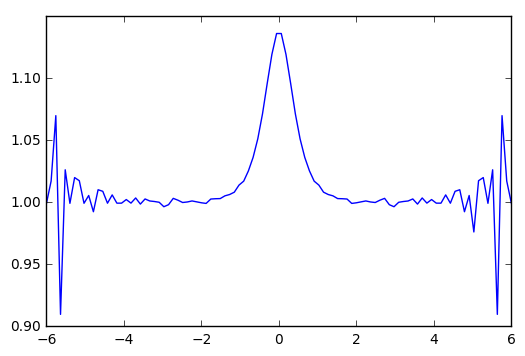

In [16]:
#Computation of division of case with inclusion and withouth inclusion - slab transmitance case

Npoints= 100
index = np.linspace(-6,6, Npoints)

fluence_2d_slab2 = []
fluence_2d_inc_slab2 = []
fluence_2d_back_slab2 = []
foreground_slab2 = []
background_slab2 = []
M=3
for i in index:
    foreground_slab2 = Phi_Slab ([i,0,4.], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)
    background_slab2 = Phi_Slab ([i,0,4.], [0,0,0], tissue, tissue, inclusion_geo, 0.)
    fluence_2d_slab2.append(foreground_slab2/background_slab2)
    fluence_2d_back_slab2.append(background_slab2)
    fluence_2d_inc_slab2.append(foreground_slab2)

plot(index, fluence_2d_slab2)

M=3
fluence_2d_slab = []
fluence_2d_inc_slab = []
fluence_2d_back_slab = []
foreground_slab = []
background_slab = []

for i in index:
    foreground_slab = Phi_Slab ([i,0,0.00001], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)[0]
    background_slab = Phi_Slab ([i,0,0.00001], [0,0,0], tissue, tissue, inclusion_geo, 0.)[0]     
    fluence_2d_slab.append(foreground_slab/background_slab)
    fluence_2d_back_slab.append(background_slab)
    fluence_2d_inc_slab.append(foreground_slab)
plot(index, fluence_2d_slab)

plot(index, fluence_2d_slab)
with open('x21_z135_n50_teo.csv','w') as f:
    np.savetxt(f, np.real(fluence_2d_slab),  delimiter="\n")

/home/nicolas/.local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


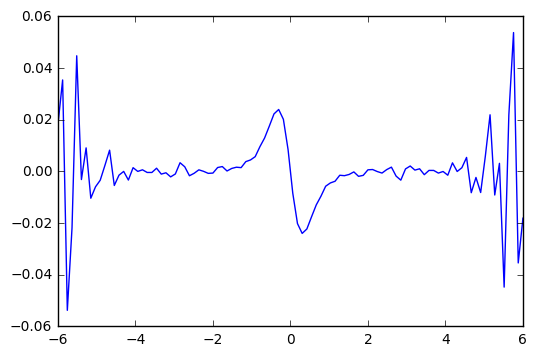

In [17]:
# Find the maximum of modulation
gradient = np.gradient(np.array(fluence_2d_slab2))
plot(index, gradient)


mod_map = []

conc_size=10
prof_size=10

for conc in linspace (10,100,num=conc_size):
    for prof in linspace (0.5, 2, num=prof_size):

zerograd = numpy.where(numpy.diff(numpy.sign(gradient)))[0]
index[zerograd]
modulation = np.abs(1-fluence_2d_slab[zerograd])
modulation

sources = Phi_Slab ([0,0,0.00001], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)[1]
inclusions = Phi_Slab ([0,0,0.00001], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)[2]
print sources
print inclusions

/home/nicolas/.local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


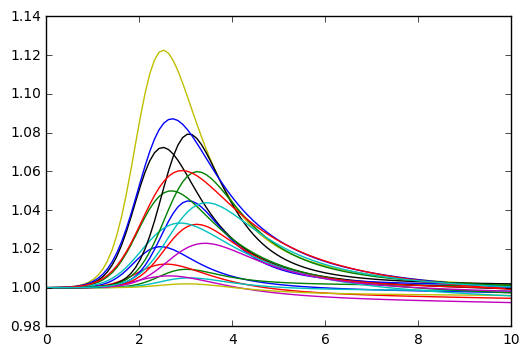

In [15]:
# Generate profiles and export to output files

Npoints= 100
index = np.linspace(0, 10, Npoints)
for Ninc in (30, 50, 70):
    for dinc in (1.15, 1.35, 1.55):
        for sinc in (2.1, 2.7):

            w = 0.
            d = 5. #Slab width
            N_tissue = 10
            N_inclusion = Ninc
            mua_ex_medium = 0.04+N_tissue*1e-9*339625
            mua_ex_inc = 0.08+N_inclusion*1e-9*339625
            mua_fl_medium = 0.04+N_tissue*1e-9*219500
            mua_fl_inc = 0.08+N_inclusion*1e-9*219500
            tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) #mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau
            inclusion = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9) #mua (muadye_ex), mups, muaf (muadye_fl), mupsf, sigma, concentration, tau
            inclusion_geo = [-(sinc),0,dinc] #object containing the inclusion position - maybe it should contain size also
            inclusion_radius = 0.595
            source = [0.,0.,0.]
            fluence_2d_slab2 = []
            fluence_2d_inc_slab2 = []
            fluence_2d_back_slab2 = []
            foreground_slab2 = []
            background_slab2 = []
            outarray = []

            for i in index:
                foreground_slab2 = Phi_Slab2 ([i,0,0.0000001], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)
                background_slab2 = Phi_Slab2 ([i,0,0.0000001], [0,0,0], tissue, tissue, inclusion_geo, 0.00001)
                fluence_2d_slab2.append(foreground_slab2/background_slab2)
                fluence_2d_back_slab2.append(background_slab2)
                fluence_2d_inc_slab2.append(foreground_slab2)

            path="/home/nicolas/Documentos/Universidad/Sources/Fluorescencia semi_inf/"
            
            outarray=np.vstack([index,np.real(fluence_2d_slab2)]).T
            with open(path + "teo_x"+ str(np.abs(inclusion_geo[0])).translate('.') + \
                      "_z" + str(inclusion_geo[2]).translate('.') + "_n" + str(N_inclusion).translate('.') + ".dat",'wb') as f:
                savetxt(f, outarray)
    
            plot(index, fluence_2d_slab2)

In [ ]:
plt.plot(fluence_2d_back_slab, 'r')
plt.plot(fluence_2d_inc_slab, 'b')
plt.yscale('log')
plt.show()

In [ ]:
fluence_2d_slab = []
fluence_2d_inc_slab = []
fluence_2d_back_slab = []
foreground_slab = []
background_slab = []

for conc in range (10,20):
    N_tissue = 10
    N_inclusion = conc
    mua_ex_medium = 0.04+N_tissue*0.0003531
    mua_ex_inc = 0.08+N_inclusion*0.0003531
    mua_fl_medium = 0.04+N_tissue*0.0002195
    mua_fl_inc = 0.08+N_inclusion*0.0002195
    print (mua_ex_medium, mua_fl_medium, mua_ex_inc, mua_fl_inc)
    tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) #mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau
    inclusion = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9) 
    for i in index:
        foreground_slab = Phi_Slab ([i,0,0.00001], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)[0]
        background_slab = Phi_Slab ([i,0,0.00001], [0,0,0], tissue, tissue, inclusion_geo, 0.)[0]     
        fluence_2d_slab.append(foreground_slab/background_slab)
        fluence_2d_back_slab.append(background_slab)
        fluence_2d_inc_slab.append(foreground_slab)
    
    
#plot(index, fluence_2d_semiinf)

In [ ]:
plt.plot(fluence_2d_back_inf, 'r')
plt.plot(fluence_2d_inc_inf, 'b')
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(fluence_2d_inf, 'r')
plt.plot(fluence_2d_slab2, 'b')
plt.show()

In [ ]:
plt.plot(fluence_2d_back, 'r')
plt.plot(fluence_2d_inc, 'b')
plt.yscale("log")
plt.show()

In [ ]:
#2D plots
x_size = 50
y_size = 50
fluence_slab = np.zeros((x_size+1,y_size+1))
print(linspace(-x_size/2,x_size/2,num=x_size+1))
for i in linspace(-x_size/2,x_size/2,num=x_size+1):
    for j in linspace(-y_size/2,y_size/2,num=y_size+1):
        fluence_slab [i+x_size/2,j+y_size/2] = Phi_Slab([i,j,0.00001], [0,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)[0]/ \
        Phi_Slab ([i,j,0.00001], [0,0,0], tissue, inclusion, inclusion_geo, 0.)[0]

In [ ]:
#2D plots
lat_size = 50
d = 0.2
fluence_homo = np.zeros((lat_size,lat_size))
for i in range(lat_size):
    for j in range(lat_size):
        fluence_homo [i,j] = Phi_Slab2([(i-lat_size/2)*d,(j-lat_size/2)*d,0.00001], [-4,0,0], tissue, tissue, inclusion_geo, inclusion_radius)

In [ ]:
plt.imshow(fluence_homo.T)
cbar = plt.colorbar()

In [ ]:
#2D plots

inclusion_geo = [2,0,1.35] #object containing the inclusion position [x,y,z]- maybe it should contain size also
inclusion_radius = 0.57
lat_size = 50
d = 0.2  
fluence_het = np.zeros((lat_size,lat_size))
for i in range(lat_size):
    for j in range(lat_size):
        fluence_het [i,j] = Phi_Slab2([(i-lat_size/2)*d,(j-lat_size/2)*d,0.00001], [-4,0,0], tissue, inclusion, inclusion_geo, inclusion_radius)



In [ ]:
plt.imshow(fluence_het.T/fluence_homo.T)
cbar = plt.colorbar()

In [ ]:
mod_map = []

conc_size=10
prof_size=10


for conc in linspace (10,50,num=conc_size):
    for absorb in linspace (0.02, 0.08, num=prof_size):
        mod_profile = []
        for j in linspace(-10,10, num=20):
            mua_ex_inc = absorb+conc*0.0003531
            mua_fl_inc = absorb+conc*0.0002195
            inclusion_test = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9) #mua, mups, muaf, mupsf, sigma, concentration, tau
            mod_profile.append(np.real(1-(Phi_Slab ([j,0,prof],[0,0,0], tissue, inclusion_test, inclusion_geo, inclusion_radius)[0]/
                                         Phi_Slab ([j,0,prof],[0,0,0], tissue, tissue, inclusion_geo, 0.)[0])))
        mod_map.append([conc,
                            prof, 
                            float(max(mod_profile))])
           

In [ ]:
imgplot = plt.imshow(mod_map, aspect='auto')
plt.colorbar()
print(mod_map)

In [65]:
# Parameters initialization
L = 10 #Number of bessel functions
n = 1.33
v = 29979245800/n 
M0 = 1
w = 0.

# Calculo sensibilidad
def RefSensCalc (po_tissue, po_inclusion, rad_inc, depth_inc):

    # Variable parameters
    n = 1.33
    d = 5 #Slab width
    
    print(po_inclusion.mua ,po_inclusion.muaf)
    #tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) #mua (muatis_ex), mups, muaf (muatis_fl), mupsf, sigma, concentration, tau
    #inclusion = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9) #mua (muadye_ex), mups, muaf (muadye_fl), mupsf, sigma, concentration, tau
    #inclusion_radius = 0.01
    source = [0.,0.,0.]

    #y coordinate index for calculations and plots
    Npoints= 100
    index = np.linspace(0, 10, Npoints)
    #depth = 1.0
    Npoints_inc = 30
    Max_distance = 15

    Rad_Prof_Sens = []

    for ig in np.linspace(0, Max_distance, Npoints_inc):
        fluence_2d_slab2 = []
        fluence_2d_inc_slab2 = []
        fluence_2d_back_slab2 = []
        foreground_slab2 = []
        background_slab2 = []
        M=2
        #print (ig)
        for i in index:
            foreground_slab2 = Phi_Slab2 ([i,0,0.000001], [0,0,0], po_tissue, po_inclusion, [-ig,0,depth_inc], rad_inc)
            background_slab2 = Phi_Slab2 ([i,0,0.000001], [0,0,0], po_tissue, po_tissue, [-ig,0,depth_inc], 0.0000001)
            fluence_2d_slab2.append(foreground_slab2/background_slab2)
            fluence_2d_back_slab2.append(background_slab2)
            fluence_2d_inc_slab2.append(foreground_slab2)
        #plot(index, fluence_2d_slab2)
        Rad_Prof_Sens.append(np.amax(fluence_2d_slab2)-1)
    
    Rad_Prof_Sens = np.real(Rad_Prof_Sens)/np.amax(np.real(Rad_Prof_Sens))
    return Rad_Prof_Sens


In [83]:
N_tissue=10
#N_inclusion=400
mua_ex_medium = 0.04+N_tissue*1e-9*339625
#mua_ex_inc = 0.12+N_inclusion*1e-9*339625
mua_fl_medium = 0.04+N_tissue*1e-9*219500
#mua_fl_inc = 0.12+N_inclusion*1e-9*219500

tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) 

inclusions = []
inclusions_N = []
for N_inclusion in range(100, 1000,200):
    mua_ex_inc = 0.12+N_inclusion*1e-9*339625
    mua_fl_inc = 0.12+N_inclusion*1e-9*219500
    inclusions.append(PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9))
    inclusions_N.append(N_inclusion)

In [84]:
Rad_Prof_Sens_Ninc = [RefSensCalc(tissue, inc,  0.01, 1) for inc in inclusions]

0.1539625 0.14195
0.22188750000000002 0.18585000000000002
0.28981250000000003 0.22975
0.35773750000000004 0.27365
0.4256625 0.31755


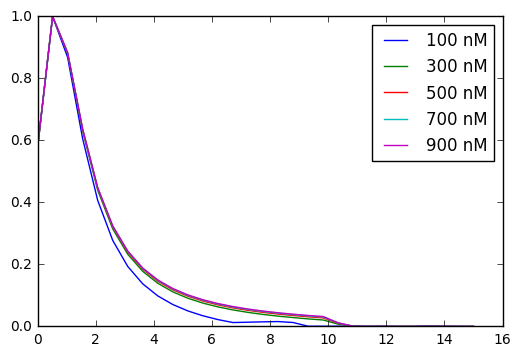

In [89]:
fig = plt.figure()
k=0;
for i in Rad_Prof_Sens_Ninc:
    plt.plot(np.linspace(0, 15, 30),i, label=str(inclusions_N[k])+" nM")
    k+=1
plt.legend()
#fig.savefig("ResSens_vsNinc.png" )

In [92]:
#N_tissue=10
N_inclusion=500
#mua_ex_medium = 0.04+N_tissue*1e-9*339625
mua_ex_inc = 0.12+N_inclusion*1e-9*339625
#mua_fl_medium = 0.04+N_tissue*1e-9*219500
mua_fl_inc = 0.12+N_inclusion*1e-9*219500

#tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) 
inclusion = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9)

tissues = []
tissues_N = []
for N_tissue in range(10, 50,10):
    mua_ex_medium = 0.04+N_tissue*1e-9*339625
    mua_fl_medium = 0.04+N_tissue*1e-9*219500
    tissues.append(PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9))
    tissues_N.append(N_tissue)

In [95]:
Rad_Prof_Sens_Ntissues = [RefSensCalc(tiss, inclusion,  0.01, 1) for tiss in tissues]

0.28981250000000003 0.22975
0.28981250000000003 0.22975
0.28981250000000003 0.22975
0.28981250000000003 0.22975


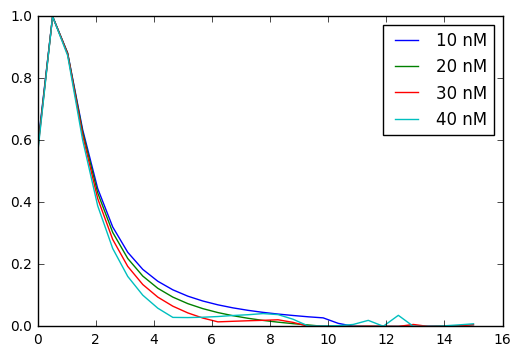

In [97]:
fig = plt.figure()
k=0;
for i in Rad_Prof_Sens_Ntissues:
    plt.plot(np.linspace(0, 15, 30),i, label=str(tissues_N[k])+" nM")
    k+=1
plt.legend()
fig.savefig("ResSens_vsNmedium.png" )

In [99]:
N_tissue=10
N_inclusion=500
mua_ex_medium = 0.04+N_tissue*1e-9*339625
mua_ex_inc = 0.12+N_inclusion*1e-9*339625
mua_fl_medium = 0.04+N_tissue*1e-9*219500
mua_fl_inc = 0.12+N_inclusion*1e-9*219500

tissue = PO(mua_ex_medium, 9.6, mua_fl_medium, 9.6, 6e4, N_tissue*1e-9, 0.58e-9) 
inclusion = PO(mua_ex_inc, 9.6, mua_fl_inc, 9.6, 6e4, N_inclusion*1e-9, 0.58e-9)

depths = arange(0.5,3,0.5)

Rad_Prof_Sens_Depths = [RefSensCalc(tissue, inclusion,  0.01, depth) for depth in arange(0.5,3,0.5)]

0.28981250000000003 0.22975
0.28981250000000003 0.22975
0.28981250000000003 0.22975
0.28981250000000003 0.22975
0.28981250000000003 0.22975


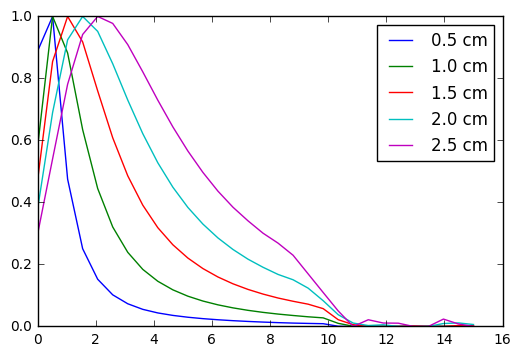

In [101]:
fig = plt.figure()
k=0;
for i in Rad_Prof_Sens_Depths:
    plt.plot(np.linspace(0, 15, 30),i, label=str(depths[k])+" cm")
    k+=1
plt.legend()
fig.savefig("ResSens_vsDepths.png" )

In [14]:
def ToXY(rd_array, dr, Nr, dx, Nx, dy, Ny, x0, y0):
    xy_array = zeros((Nx,Ny), float)
    for x in range(Nx):
        for y in range(Ny):
            xpos = (x+0.5-Nx/2)*dx
            ypos = (y+0.5-Ny/2)*dy
            r_xy2 = (xpos-x0)**2 + (ypos-y0)**2
            if r_xy2 < (Nr*dr)**2 and r_xy2 > 0.5:
                #rd_pos = 0
                #for i in range(Nr):
                #    if (sqrt(r_xy2) - float(rd_array[i][0])) <= dr:
                #        rd_pos = i
                #        break
                #xy_array[x][y] = float(rd_array[rd_pos][1])
                r_interpolated = interpolate.interp1d([row[0] for row in col_array],[row[1] for row in col_array], kind='cubic')
                xy_array[x][y] = r_interpolated(sqrt(r_xy2))
            else:
                xy_array[x][y] = 1
    print(shape(xy_array))
    return xy_array

In [13]:
col_array=np.column_stack((np.linspace(0, Max_distance, Npoints_inc),np.real(Rad_Prof_sens)))
#print ([row[1] for row in col_array])
#print (col_array)
#XY_Prof_Sens = ToXY (col_array, Max_distance/Npoints_inc, Npoints_inc, 0.04, 250, 0.04, 250, 0, -4)

In [14]:
print(np.real(Rad_Prof_sens))

[  1.41188172e-10   1.98249861e-10   2.56046517e-10   3.06580761e-10
   3.43905571e-10   3.66024100e-10   3.73571396e-10   3.69776876e-10
   3.57517127e-10   3.39886785e-10   3.19312798e-10   2.97542657e-10
   2.75744538e-10   2.54711807e-10   2.34793740e-10   2.16145102e-10
   1.98985273e-10   1.83371984e-10   1.69085634e-10   1.55964130e-10
   1.44030343e-10   1.33285605e-10   1.23395294e-10   1.14366294e-10
   1.06252340e-10   9.86641879e-11   9.18001231e-11   8.55806537e-11
   7.96676058e-11   7.43904938e-11   6.96529501e-11   6.50048904e-11
   6.10567152e-11   5.65201219e-11   5.39150946e-11   4.94468910e-11
   4.65907313e-11   3.98903133e-11   3.34903216e-11   2.48161491e-11
   1.68203229e-11   1.03264064e-11   6.87649937e-12   2.86304314e-12
   1.38045131e-12   0.00000000e+00   1.36335387e-12   0.00000000e+00
   9.53459534e-13   1.38333789e-13   0.00000000e+00   0.00000000e+00
   2.79776202e-14   0.00000000e+00   1.18483001e-12   2.33280062e-12
   3.66018327e-12   0.00000000e+00

In [15]:
#savetxt("teo_sens2" + "_z" + str(depth).translate(".") + ".dat", col_array, fmt="%.30e")